In [1]:
import time
import glob as glob
import torch
import cv2
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


from config import DEVICE, NUM_CLASSES, NUM_EPOCHS , OUT_DIR , RESIZE_TO, CLASSES
from model import create_model
from utils import Averager
from datasets import train_loader, valid_loader

/home/ubuntu/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of training samples: 155
Number of validation samples: 20



In [2]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for _, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        anchor = model(images, targets)
        positive = model(images, targets)
        negative = model(images, targets)

        anchor_loss = sum(loss for loss in anchor.values())
        positive_loss = sum(loss for loss in positive.values())
        negative_loss = sum(loss for loss in negative.values())

        losses = criterion(anchor_loss, positive_loss, negative_loss)
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [3]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for _, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            anchor_valid = model(images, targets)
            positive_valid = model(images, targets)
            negative_valid = model(images, targets)


        anchor_valid_loss = sum(loss for loss in anchor_valid.values())
        positive_valid_loss = sum(loss for loss in positive_valid.values())
        negative_valid_loss = sum(loss for loss in negative_valid.values())

        losses = criterion(anchor_valid_loss, positive_valid_loss, negative_valid_loss)
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [4]:
# Model initialization and setup
model = create_model(num_classes=NUM_CLASSES).to(DEVICE)

# Get parameters that require gradient
params = [p for p in model.parameters() if p.requires_grad]

# Define loss function and optimizer
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=0.01, swap=False, reduction='mean')
optimizer = torch.optim.SGD(params, lr=2e-9, momentum=0.4, weight_decay=5e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.7, patience=3, verbose = True)
min_loss = np.inf

# Initialize loss trackers
train_loss_hist = Averager()
val_loss_hist = Averager()

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# Initialize loss lists
train_loss_list = []
val_loss_list = []

train_losses = []
val_losses = []

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset loss histories
    train_loss_hist.reset()
    val_loss_hist.reset()

    # Time the training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")
    train_losses.append(train_loss_hist.value)
    val_losses.append(val_loss_hist.value)
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch+1}")

    # Save model if validation loss is less than minimum loss
    if val_loss_hist.value < min_loss:
        min_loss = val_loss_hist.value
        torch.save(model.state_dict(), f"{OUT_DIR}/Model_{epoch}.pth")
        print("Model saved")
    
    # Update the learning rate
    scheduler.step(val_loss_hist.value)


training = 'done'


EPOCH 1 of 40
Training


Loss: 1.8040: 100%|██████████| 10/10 [00:13<00:00,  1.34s/it]


Validating


Loss: 1.7444: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Epoch #1 train loss: 1.873
Epoch #1 validation loss: 1.749
Took 0.247 minutes for epoch 1
Model saved

EPOCH 2 of 40
Training


Loss: 1.7920: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Validating


Loss: 1.7463: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch #2 train loss: 1.880
Epoch #2 validation loss: 1.752
Took 0.203 minutes for epoch 2

EPOCH 3 of 40
Training


Loss: 1.7945: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Validating


Loss: 1.7480: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch #3 train loss: 1.866
Epoch #3 validation loss: 1.748
Took 0.207 minutes for epoch 3
Model saved

EPOCH 4 of 40
Training


Loss: 1.6984: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7546: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Epoch #4 train loss: 1.883
Epoch #4 validation loss: 1.752
Took 0.207 minutes for epoch 4

EPOCH 5 of 40
Training


Loss: 1.7556: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7455: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #5 train loss: 1.869
Epoch #5 validation loss: 1.746
Took 0.206 minutes for epoch 5
Model saved

EPOCH 6 of 40
Training


Loss: 1.8164: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Validating


Loss: 1.7379: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


Epoch #6 train loss: 1.883
Epoch #6 validation loss: 1.742
Took 0.203 minutes for epoch 6
Model saved

EPOCH 7 of 40
Training


Loss: 1.8850: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7471: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #7 train loss: 1.864
Epoch #7 validation loss: 1.747
Took 0.204 minutes for epoch 7

EPOCH 8 of 40
Training


Loss: 2.4072: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Validating


Loss: 1.7312: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Epoch #8 train loss: 1.915
Epoch #8 validation loss: 1.740
Took 0.205 minutes for epoch 8
Model saved

EPOCH 9 of 40
Training


Loss: 1.7186: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Validating


Loss: 1.7712: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Epoch #9 train loss: 1.884
Epoch #9 validation loss: 1.761
Took 0.203 minutes for epoch 9

EPOCH 10 of 40
Training


Loss: 1.8294: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7533: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch #10 train loss: 1.881
Epoch #10 validation loss: 1.752
Took 0.206 minutes for epoch 10

EPOCH 11 of 40
Training


Loss: 1.7889: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Validating


Loss: 1.7667: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch #11 train loss: 1.884
Epoch #11 validation loss: 1.760
Took 0.205 minutes for epoch 11

EPOCH 12 of 40
Training


Loss: 1.8118: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7450: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


Epoch #12 train loss: 1.894
Epoch #12 validation loss: 1.748
Took 0.209 minutes for epoch 12

EPOCH 13 of 40
Training


Loss: 1.7673: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


Validating


Loss: 1.7374: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Epoch #13 train loss: 1.866
Epoch #13 validation loss: 1.744
Took 0.200 minutes for epoch 13

EPOCH 14 of 40
Training


Loss: 1.7688: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Validating


Loss: 1.7564: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Epoch #14 train loss: 1.875
Epoch #14 validation loss: 1.752
Took 0.207 minutes for epoch 14

EPOCH 15 of 40
Training


Loss: 1.8043: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7637: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #15 train loss: 1.873
Epoch #15 validation loss: 1.757
Took 0.207 minutes for epoch 15

EPOCH 16 of 40
Training


Loss: 1.7677: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Validating


Loss: 1.7337: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Epoch #16 train loss: 1.871
Epoch #16 validation loss: 1.742
Took 0.204 minutes for epoch 16

EPOCH 17 of 40
Training


Loss: 1.7955: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Validating


Loss: 1.7444: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch #17 train loss: 1.887
Epoch #17 validation loss: 1.745
Took 0.207 minutes for epoch 17

EPOCH 18 of 40
Training


Loss: 1.8198: 100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Validating


Loss: 1.7550: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Epoch #18 train loss: 1.867
Epoch #18 validation loss: 1.754
Took 0.207 minutes for epoch 18

EPOCH 19 of 40
Training


Loss: 1.8372: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Validating


Loss: 1.7603: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #19 train loss: 1.878
Epoch #19 validation loss: 1.758
Took 0.209 minutes for epoch 19

EPOCH 20 of 40
Training


Loss: 1.8530: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Validating


Loss: 1.7520: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Epoch #20 train loss: 1.879
Epoch #20 validation loss: 1.750
Took 0.206 minutes for epoch 20

EPOCH 21 of 40
Training


Loss: 2.4113: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7633: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch #21 train loss: 1.906
Epoch #21 validation loss: 1.758
Took 0.203 minutes for epoch 21

EPOCH 22 of 40
Training


Loss: 1.7748: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7693: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


Epoch #22 train loss: 1.873
Epoch #22 validation loss: 1.759
Took 0.205 minutes for epoch 22

EPOCH 23 of 40
Training


Loss: 1.7425: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7120: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


Epoch #23 train loss: 1.876
Epoch #23 validation loss: 1.731
Took 0.206 minutes for epoch 23
Model saved

EPOCH 24 of 40
Training


Loss: 1.8126: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Validating


Loss: 1.7447: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #24 train loss: 1.875
Epoch #24 validation loss: 1.750
Took 0.202 minutes for epoch 24

EPOCH 25 of 40
Training


Loss: 2.2475: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7480: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Epoch #25 train loss: 1.886
Epoch #25 validation loss: 1.751
Took 0.205 minutes for epoch 25

EPOCH 26 of 40
Training


Loss: 1.7768: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Validating


Loss: 1.7346: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #26 train loss: 1.892
Epoch #26 validation loss: 1.742
Took 0.204 minutes for epoch 26

EPOCH 27 of 40
Training


Loss: 1.7540: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Validating


Loss: 1.7345: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


Epoch #27 train loss: 1.854
Epoch #27 validation loss: 1.745
Took 0.205 minutes for epoch 27

EPOCH 28 of 40
Training


Loss: 1.7926: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Validating


Loss: 1.7475: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #28 train loss: 1.851
Epoch #28 validation loss: 1.748
Took 0.209 minutes for epoch 28

EPOCH 29 of 40
Training


Loss: 1.7551: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Validating


Loss: 1.7537: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


Epoch #29 train loss: 1.887
Epoch #29 validation loss: 1.752
Took 0.205 minutes for epoch 29

EPOCH 30 of 40
Training


Loss: 1.8938: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Validating


Loss: 1.7462: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #30 train loss: 1.866
Epoch #30 validation loss: 1.749
Took 0.204 minutes for epoch 30

EPOCH 31 of 40
Training


Loss: 1.7528: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7829: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch #31 train loss: 1.892
Epoch #31 validation loss: 1.763
Took 0.209 minutes for epoch 31

EPOCH 32 of 40
Training


Loss: 1.8094: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7540: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Epoch #32 train loss: 1.870
Epoch #32 validation loss: 1.754
Took 0.203 minutes for epoch 32

EPOCH 33 of 40
Training


Loss: 1.8749: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7669: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


Epoch #33 train loss: 1.878
Epoch #33 validation loss: 1.759
Took 0.209 minutes for epoch 33

EPOCH 34 of 40
Training


Loss: 1.8007: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Validating


Loss: 1.7508: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #34 train loss: 1.861
Epoch #34 validation loss: 1.749
Took 0.202 minutes for epoch 34

EPOCH 35 of 40
Training


Loss: 1.7729: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Validating


Loss: 1.7369: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Epoch #35 train loss: 1.881
Epoch #35 validation loss: 1.742
Took 0.210 minutes for epoch 35

EPOCH 36 of 40
Training


Loss: 1.8138: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7362: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #36 train loss: 1.888
Epoch #36 validation loss: 1.744
Took 0.206 minutes for epoch 36

EPOCH 37 of 40
Training


Loss: 1.8457: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7562: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


Epoch #37 train loss: 1.871
Epoch #37 validation loss: 1.752
Took 0.206 minutes for epoch 37

EPOCH 38 of 40
Training


Loss: 1.7790: 100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


Validating


Loss: 1.7584: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Epoch #38 train loss: 1.879
Epoch #38 validation loss: 1.752
Took 0.208 minutes for epoch 38

EPOCH 39 of 40
Training


Loss: 1.8273: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Validating


Loss: 1.7512: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Epoch #39 train loss: 1.872
Epoch #39 validation loss: 1.748
Took 0.205 minutes for epoch 39

EPOCH 40 of 40
Training


Loss: 1.7915: 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Validating


Loss: 1.7496: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

Epoch #40 train loss: 1.879
Epoch #40 validation loss: 1.747
Took 0.202 minutes for epoch 40


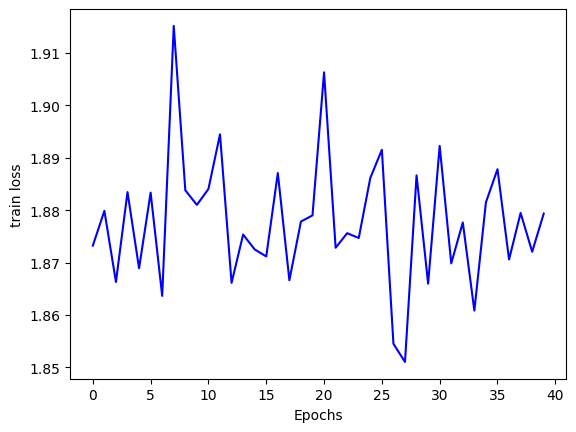

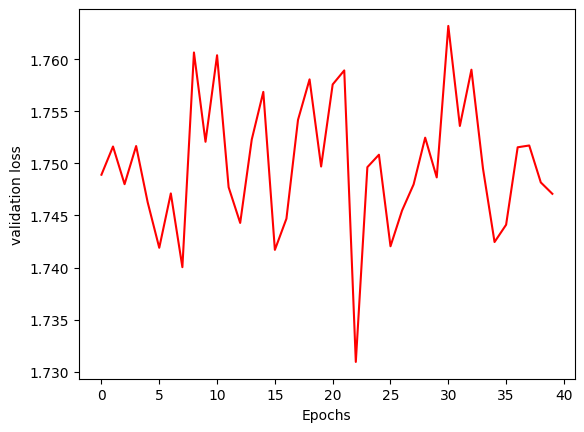

In [7]:
figure_1, train_ax = plt.subplots()
figure_2, valid_ax = plt.subplots()
plt.ticklabel_format(style='plain', axis='x', useOffset=False)
# save the model and plots after training

if training == 'done': 
    train_ax.plot(train_losses, color='blue')
    train_ax.set_xlabel('Epochs')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_losses, color='red')
    valid_ax.set_xlabel('Epochs')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")

    torch.save(model.state_dict(), f"{OUT_DIR}/Model_final.pth")

In [8]:
torch.cuda.empty_cache()

In [14]:
from datasets import valid_dataset
from utils import collate_fn
from torch.utils.data import DataLoader

valid_test_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [48]:
prog_bar = tqdm(valid_test_loader, total=len(valid_test_loader))

true_vals = []
pred_vals = []  
    
for i, data in enumerate(prog_bar):
    images, targets = data
        
    images = list(image.to(DEVICE) for image in images)
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    true_classes = targets[i]['labels'].cpu().numpy().tolist()
    true_vals.append(true_classes)
    
    model.eval()
    with torch.no_grad():
        output = model(images, targets)

    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in output]

    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # print(scores)
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= 0.45].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = outputs[0]['labels'].cpu().numpy().tolist()
        
        pred_classes = pred_classes[:len(true_classes)]
        pred_vals.append(pred_classes)


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Test instances: 20


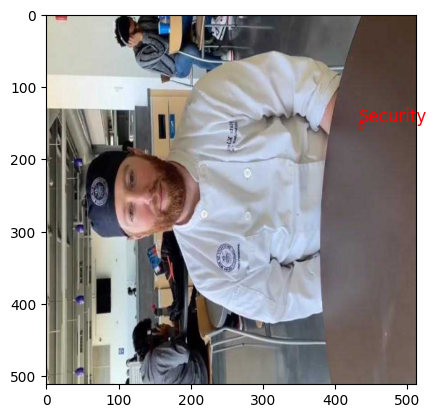

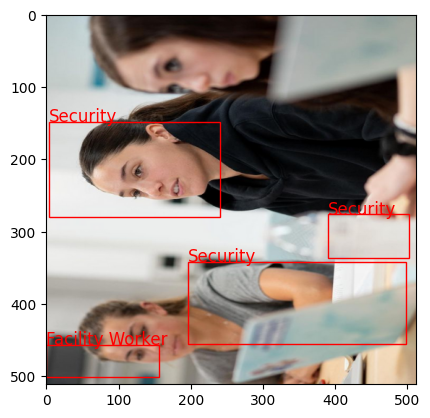

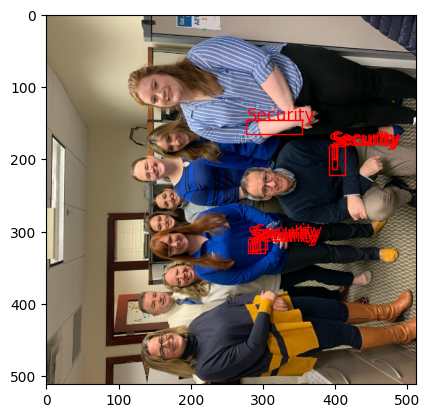

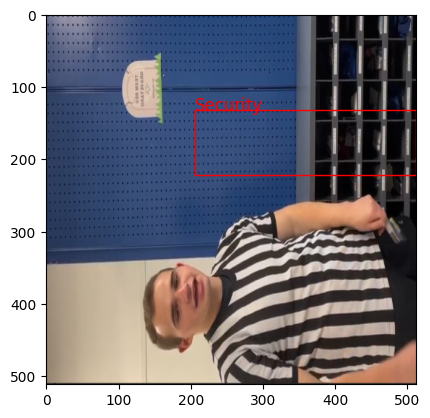

In [53]:
model = create_model(num_classes=NUM_CLASSES).to(DEVICE)

#Taking the best model
model.load_state_dict(torch.load(f"{OUT_DIR}/Model_22.pth"))

model.eval()
  
DIR_TEST = 'dataset/test'
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")

# print(test_images)
test_images = test_images[:4]

for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[i].split('/')[-1].split('.')[0]
    # print(image_name)
    image = cv2.imread(test_images[i])
    # print(image)
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # resize to the model input size
    image = cv2.resize(image, (RESIZE_TO, RESIZE_TO))
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    
    with torch.no_grad():
        outputs = model(image)
    
    
    
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()

        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= 0.40].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        fig, axs = plt.subplots()
        
        image = image.permute(0, 3, 2, 1).cpu().numpy()
        image = image.squeeze()
        axs.imshow(image)
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(boxes):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red')
            axs.add_patch(rect)
            axs.text(x1, y1, pred_classes[j], fontsize=12, color='red')

        plt.show()